# Bike Rental Linear Regression Study Notebook

In [389]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [390]:
# Read the raw data. Use the dtype option to remove the warning for mixed types.
bike_sharing = pd.read_csv('../datasets/bike_sharing.csv')
bike_sharing.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [391]:
# Analyze the raw data
print('Number of rows are: ', bike_sharing.shape[0])
print('Number of cols are: ', bike_sharing.shape[1])
print('Number of duplicated rows are: ', bike_sharing.duplicated().sum())

Number of rows are:  730
Number of cols are:  16
Number of duplicated rows are:  0


In [392]:
# Number of columns with all values being null. These columns need to dropped from the dataframe
all_null_value_cols = [col for col in bike_sharing.columns if bike_sharing[col].isnull().all() == True]
print('Columns with all null values are:', all_null_value_cols)
print('Number of columns with all null values are: ', len(all_null_value_cols))

Columns with all null values are: []
Number of columns with all null values are:  0


In [393]:
# Number of columns with single values. These columns need to be dropped from the dataframe.
single_value_cols = [col for col in bike_sharing.columns if bike_sharing[col].nunique() == 1]
print('Columns with single values are:', single_value_cols)
print('Number of columns with single values are: ', len(single_value_cols))

Columns with single values are: []
Number of columns with single values are:  0


## Data Cleaning

In [394]:
# Standardize the column names and column values
# season  -> 1-SPRING, 2-SUMMER, 3-FALL, 4-WINTER
# weather -> 1-CLEAR, 2-MIST, 3-LIT_RAIN, 4-HVY_RAIN
# month   -> 1-JANUARY, 2-FEBRUARY, 3-MARCH, 4-APRIL, 5-MAY, 6-JUNE, 7-JULY, 8-AUGUST, 9-SEPTEMBER, 10-OCTOBER, 11-NOVEMBER, 12-DECEMBER
# weeday  -> 1-MONDAY, 2-TUESDAY, 3-WEDNESDAY, 4-THURSDAY, 5-FRIDAY, 6-SATURDAY, 7-SUNDAY

season_map = {1: 'SPRING', 2: 'SUMMER', 3: 'FALL', 4: 'WINTER'}
bike_sharing['season'] = bike_sharing['season'].apply(lambda x: season_map.get(x))

weather_map = {1: 'CLEAR', 2: 'MIST', 3: 'LIT_RAIN', 4: 'HVY_RAIN'}
bike_sharing['weathersit'] = bike_sharing['weathersit'].apply(lambda x: weather_map.get(x))

mnth_map = {1: 'JANUARY', 2: 'FEBRUARY', 3: 'MARCH', 4: 'APRIL', 5: 'MAY', 6: 'JUNE', 7: 'JULY', 8: 'AUGUST', 9:'SEPTEMBER', 10: 'OCTOBER', 11: 'NOVEMBER', 12: 'DECEMBER'}
bike_sharing['mnth'] = bike_sharing['mnth'].apply(lambda x: mnth_map.get(x))

weekday_map = {0: 'MONDAY', 1: 'TUESDAY', 2: 'WEDNESDAY', 3: 'THRUSDAY', 4: 'FRIDAY', 5: 'SATURDAY', 6: 'SUNDAY'}
bike_sharing['weekday'] = bike_sharing['weekday'].apply(lambda x: weekday_map.get(x))

bike_sharing.rename(columns={'yr':'year', 'mnth': 'month', 'holiday': 'is_holiday', 'weekday': 'day_of_week', 
                             'workingday': 'is_workingday', 'weathersit': 'weather_situation', 'temp': 'temperature',
                             'atemp':'ambient_temperature', 'hum': 'humidity', 'casual': 'casual_count', 
                             'registered':'registered_count', 'cnt': 'total_count'}, inplace=True)

In [395]:
# Extract the day of the month from the dteday field and drop the column
bike_sharing['day_of_month'] = pd.to_datetime(bike_sharing['dteday'], format='%d-%m-%Y').dt.day
bike_sharing = bike_sharing.drop(['instant','dteday'], axis = 1)

## EDA

In [396]:
# Bifurcate the dataset into numerical and categorical columns to perform EDA
num_columns = ["temperature", "ambient_temperature", "humidity", "windspeed", "casual_count", "registered_count", "total_count"]
cat_columns = ["season", "year", "month", "is_holiday", "day_of_week", "is_workingday", "weather_situation", "day_of_month"]

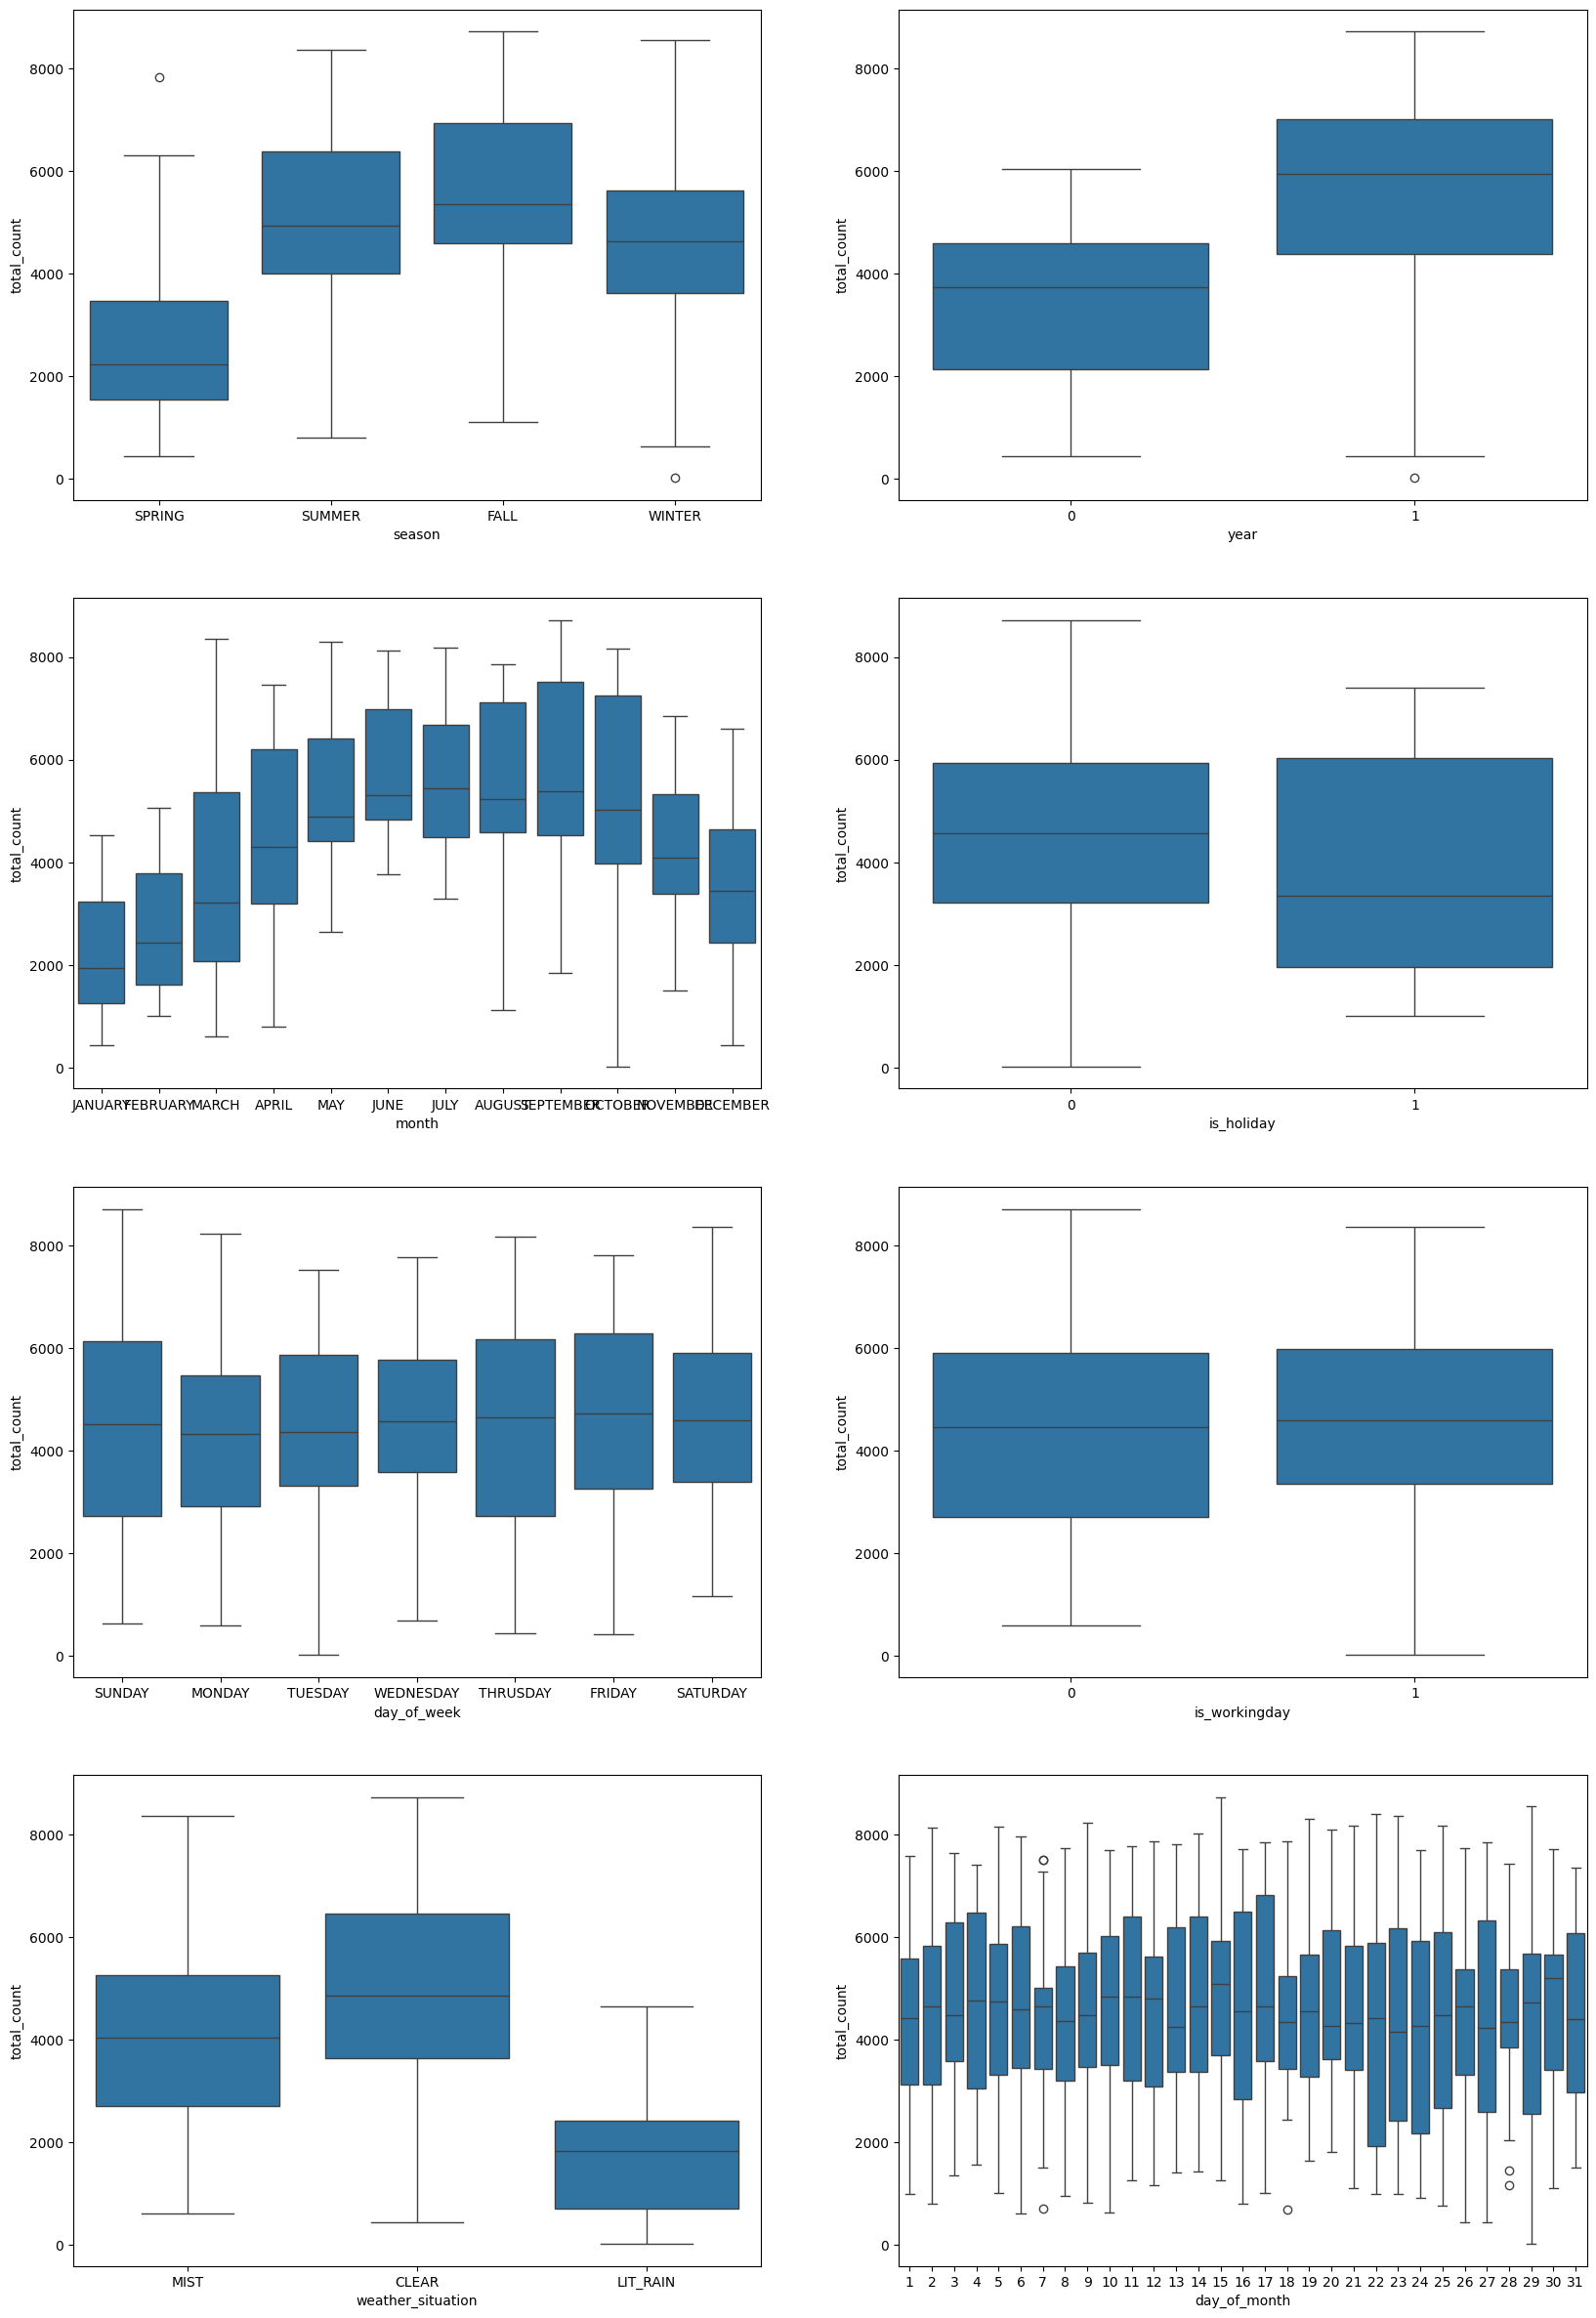

In [397]:
# Bivariate Analysis - Relationship of the count of total rental bikes with various categorical variables
# Visualise the categorical variables
plt.figure(figsize=(20, 30))

for i in range(0,len(cat_columns)):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(x = cat_columns[i], y = 'total_count', data=bike_sharing)

- Relation with season:
    - The mean count is significantly lower for season **SPRING** 
    - The mean count is highest for season = FALL
- Relation with year:
    - The mean count is significantly lower for yr = 2018
- Relation with month of year:
    - The mean count increases linearly with month peaking at **September** and reducing thereafter
- Relation with holiday:
    - The mean count is significantly less on a holiday
- Relation with day of week:
    - The mean count **does not** seem to be affected much by the day of the week
- Relation with workingday:
    - The mean count **does not** seem to be affected whether the days is working or not
- Relation with weathersit:
    - The mean count is significantly lower for days with **Light Rain**
    - The mean count is highest for days with **Clear** weather
- Relation with mnthday:
    - The mean count **does not** seem to be affected by the day of the month

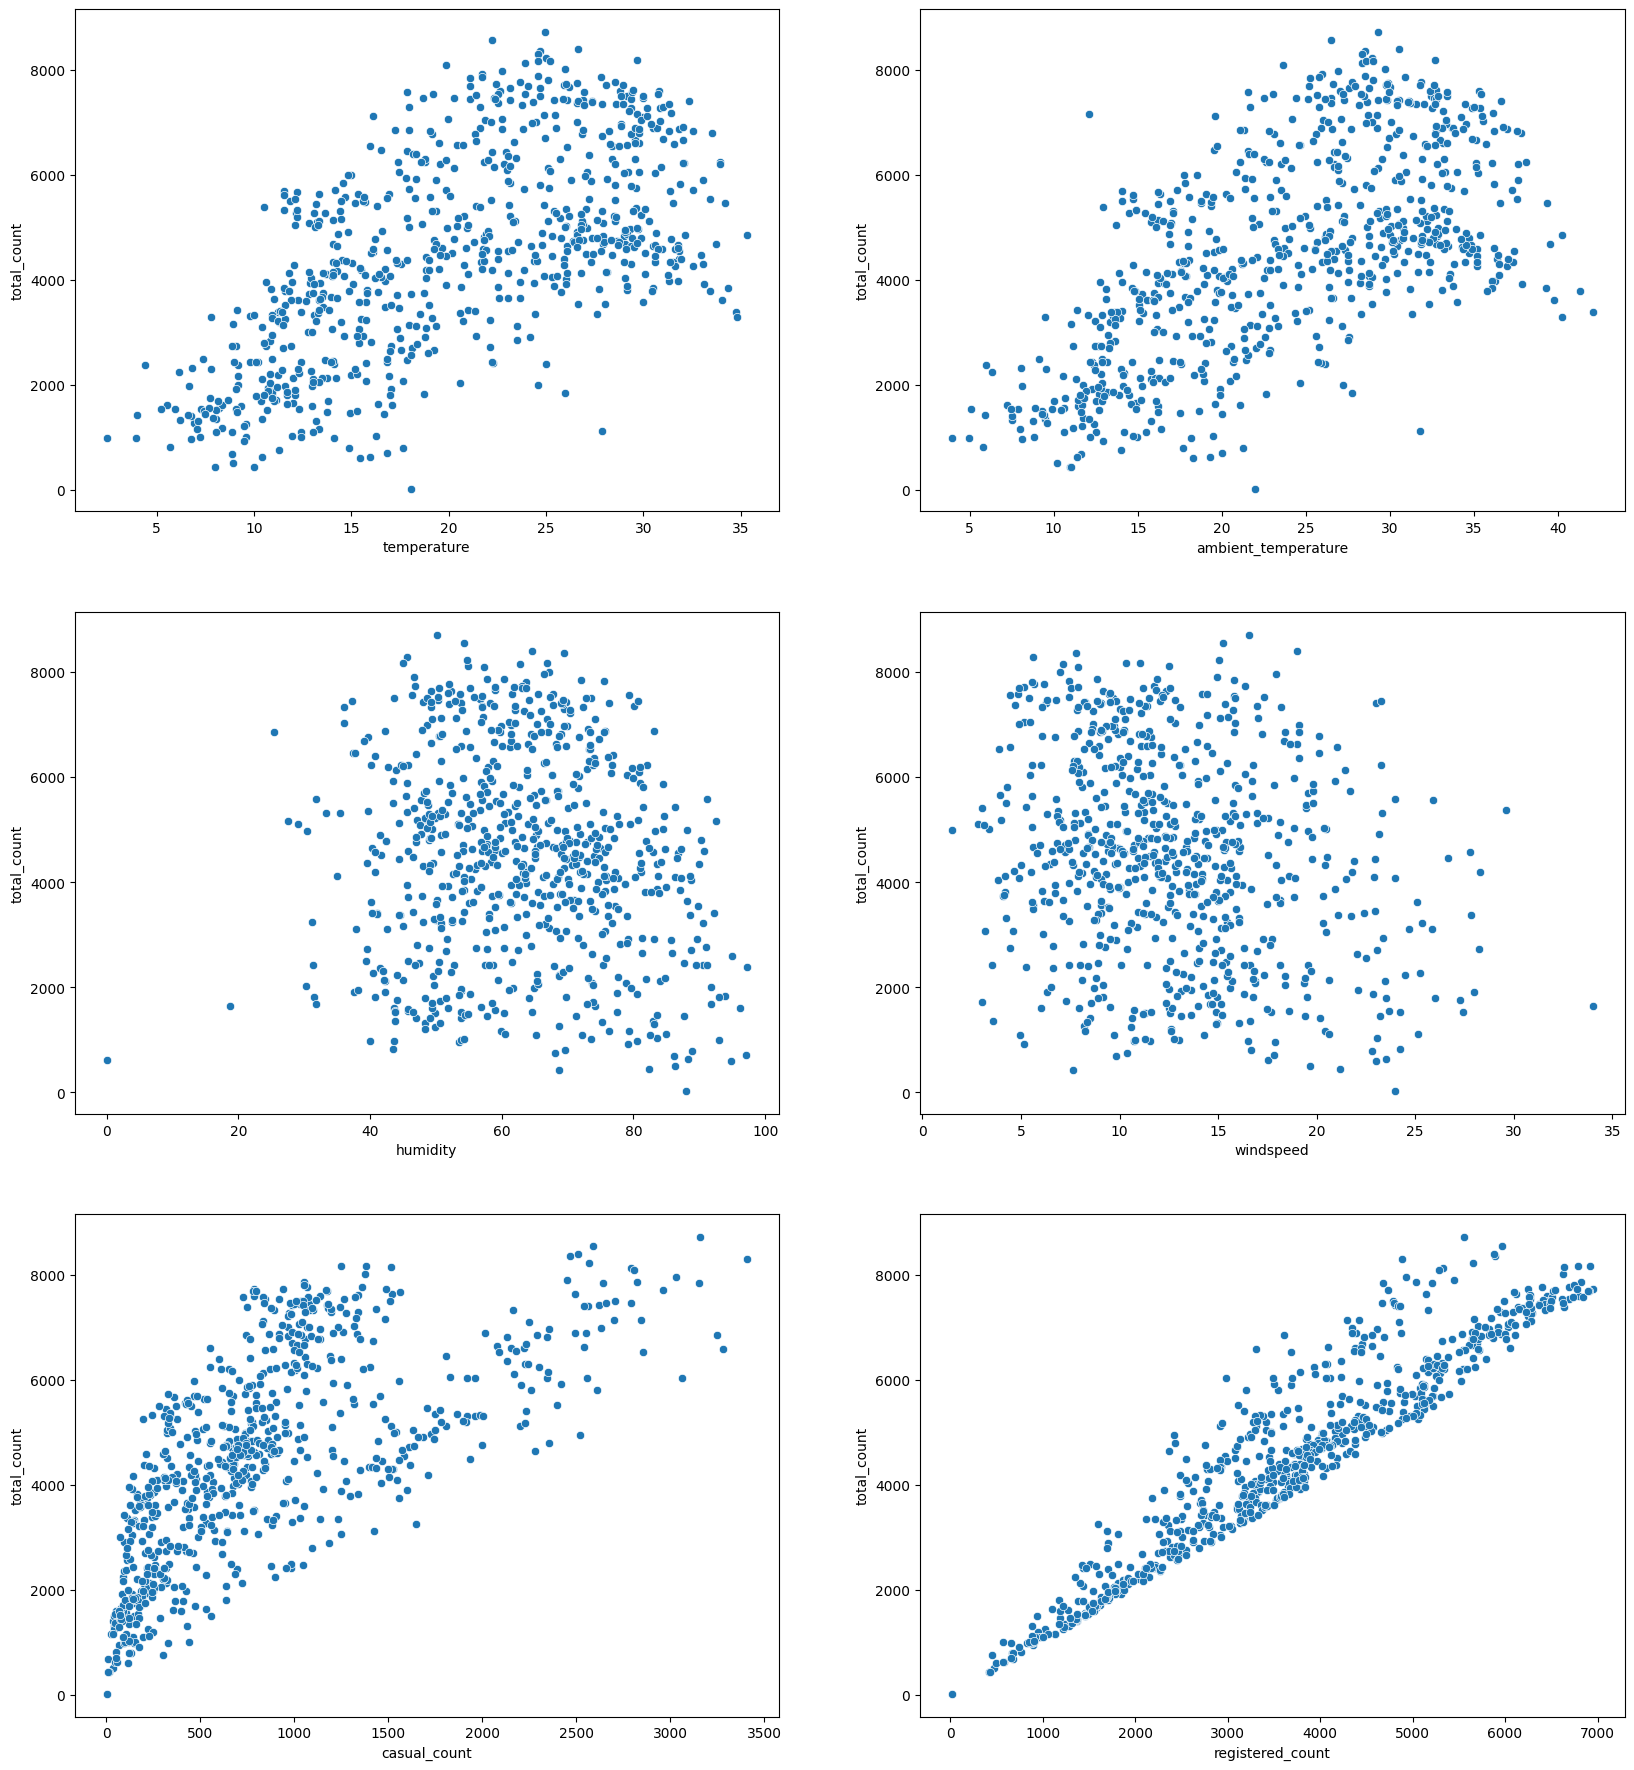

In [398]:
# Bivariate Analysis - Relationship of the count of total rental bikes with various numerical variables
# Visualise the categorical variables
plt.figure(figsize=(20, 30))

for i in range(0,len(num_columns) - 1):
    plt.subplot(4, 2, i + 1)
    sns.scatterplot(x = num_columns[i], y = 'total_count', data=bike_sharing)

- Relation with temp/atemp:
    - The count increases with increase in temperature
    - The relation of count with temp/atemp follows the same pattern. Therefore, for simplicity we can ignore one of the two.
- Relation with humidity:
    - The counts are very rare for **humidity < 40**  
- Relation with windspeed:
    - The counts are very rare for **windspeed > 25**

In [399]:
# Drop columns that do not show any relationship with the output i.e. total_count of bikes
bike_sharing = bike_sharing.drop(['is_workingday','day_of_week','day_of_month', 'ambient_temperature', 'casual_count','registered_count'], axis = 1)

## Multiple Regression Model

### Create Dummy Columns

In [400]:
# Create dummies for the categorical columns using the 'drop_first' strategy
# season, weather_situation, month

season_dummies = pd.get_dummies(bike_sharing['season'], drop_first=True)
season_dummies = season_dummies.apply(lambda x: x.map({True: 1, False: 0}))
bike_sharing = pd.concat([bike_sharing, season_dummies], axis=1)
bike_sharing = bike_sharing.drop('season', axis=1)

weather_situation_dummies = pd.get_dummies(bike_sharing['weather_situation'], drop_first=True)
weather_situation_dummies = weather_situation_dummies.apply(lambda x: x.map({True: 1, False: 0}))
bike_sharing = pd.concat([bike_sharing, weather_situation_dummies], axis=1)
bike_sharing = bike_sharing.drop('weather_situation', axis=1)

month_dummies = pd.get_dummies(bike_sharing['month'], drop_first=True)
month_dummies = month_dummies.apply(lambda x: x.map({True: 1, False: 0}))
bike_sharing = pd.concat([bike_sharing, month_dummies], axis=1)
bike_sharing = bike_sharing.drop('month', axis=1)

### Perform Test Train Split

In [401]:
# Perform the test and train split of the input data-frame
df_train, df_test = train_test_split(bike_sharing, train_size = 0.7, random_state = 100)
print("Train data size: ", df_train.shape)
print("Test data size: ", df_test.shape)

Train data size:  (510, 22)
Test data size:  (220, 22)


### Perform Scaling

In [402]:
# Perform scaling using MinMax Scaler
num_columns = ["temperature", "humidity", "windspeed", "total_count"]
scaler = MinMaxScaler()
df_train[num_columns] = scaler.fit_transform(df_train[num_columns])
df_test[num_columns] = scaler.transform(df_test[num_columns])

### Multivariate Analysis

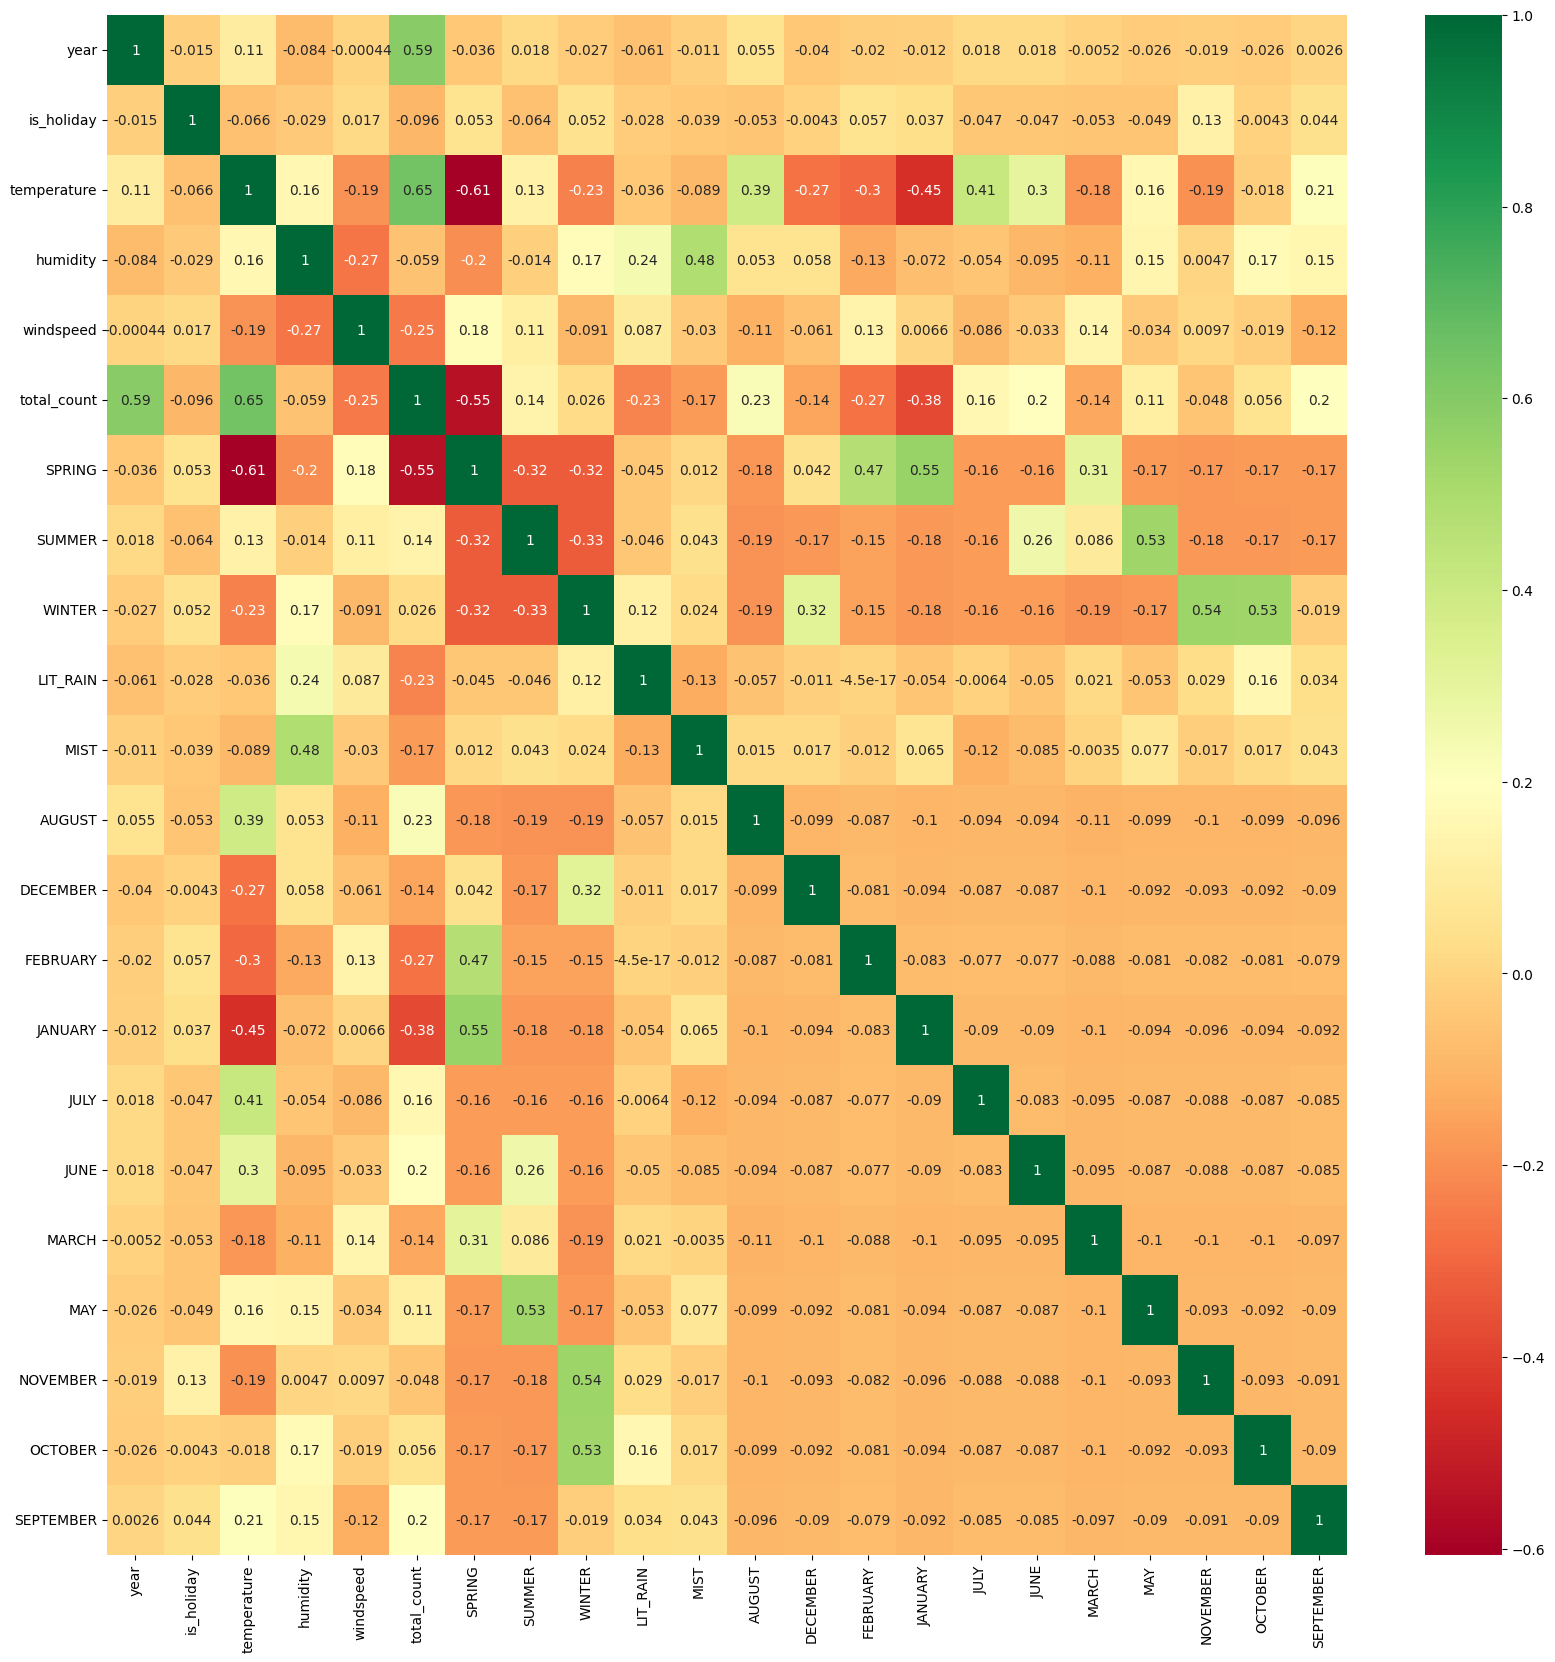

In [403]:
# Determine correlation between the Predictor Variables.
plt.figure(figsize=(20,20))
sns.heatmap(df_train.corr(), annot=True, cmap="RdYlGn")
plt.show()

In [404]:
# Seperate the independent variable from the input data frame into another dataframe
# This is to begin training the model with dependent and independent dataframes
y_train = df_train.pop('total_count')
X_train = df_train

In [405]:
def VIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return vif

### Feature Selection

In [406]:
# Perform top 15 feature selection using the Recursive Feature Elimination Technique
lrm = LinearRegression()
rfe = RFE(lrm, n_features_to_select = 15)
rfe = rfe.fit(X_train, y_train)
for index, column in zip(range(X_train.shape[1]), X_train.columns):
    if rfe.support_[index] == True:
        print(f"rank={rfe.ranking_[index]}: {column}")

rank=1: year
rank=1: is_holiday
rank=1: temperature
rank=1: humidity
rank=1: windspeed
rank=1: SPRING
rank=1: SUMMER
rank=1: WINTER
rank=1: LIT_RAIN
rank=1: MIST
rank=1: DECEMBER
rank=1: JANUARY
rank=1: JULY
rank=1: NOVEMBER
rank=1: SEPTEMBER


In [407]:
# Update the training input data to contain only the columns selected by RFE
selected_features = X_train.columns[rfe.support_]
X_train = X_train[selected_features]

### Model with constant

In [408]:
# Augument the independent variables of the training dataset with **constant**
X_train_with_constant = sm.add_constant(X_train)

# Fit the model
train_model_1 = sm.OLS(np.array(y_train), X_train_with_constant)
train_fit_1 = train_model_1.fit()
train_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.4
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          8.15e-189
Time:                        10:33:01   Log-Likelihood:                 514.19
No. Observations:                 510   AIC:                            -996.4
Df Residuals:                     494   BIC:                            -928.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3197      0.036      8.859      0.000       0.249       0.391
year            0.2304      0.008     28.487      0.000       0.215       0.246
is_holiday     -0.0911      0.026     -3.557      0.000      -0.141      -0.041
temperature     0.4815      0.037     13.005      0.000       0.409       0.554
humidity       -0.1622      0.038     -4.291      0.000      -0.236      -0.088
windspeed      -0.1887      0.026     -7.315      0.000      -0.239      -0.138
SPRING         -0.0613      0.021     -2.881      0.004      -0.103      -0.019
SUMMER          0.0423      0.015      2.761      0.006       0.012       0.072
WINTER          0.1019      0.018      5.656      0.000       0.067       0.137
LIT_RAIN       -0.2465      0.026     -9.331      0.000      -0.298      -0.195
MIST           -0.0543      0.010     -5.194      0.000      -0.075      -0.034
DECEMBER       -0.0355      0.018     -2.024      0.043      -0.070      -0.001
JANUARY        -0.0434      0.018     -2.393      0.017      -0.079      -0.008
JULY           -0.0553      0.018     -3.030      0.003      -0.091      -0.019
NOVEMBER       -0.0387      0.019     -2.057      0.040      -0.076      -0.002
SEPTEMBER       0.0755      0.017      4.466      0.000       0.042       0.109
==============================================================================
Omnibus:                       66.656   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.040
Skew:                          -0.682   Prob(JB):                     1.07e-35
Kurtosis:                       5.392   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [409]:
VIF(X_train_with_constant)

,Features,VIF
0,const,82.52
6,SPRING,5.27
3,temperature,4.42
8,WINTER,3.83
7,SUMMER,2.77
4,humidity,1.92
14,NOVEMBER,1.77
12,JANUARY,1.68
10,MIST,1.57
11,DECEMBER,1.50


In [410]:
# R2 = 0.840
# VIF's are in acceptable range, except SPRING column where VIF > 5
# Drop the SPRING column

X_train_with_constant_1 = X_train_with_constant.drop(['SPRING'], axis = 1)

train_model_2 = sm.OLS(np.array(y_train), X_train_with_constant_1)
train_fit_2 = train_model_2.fit()
train_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     188.9
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          3.50e-188
Time:                        10:33:01   Log-Likelihood:                 509.94
No. Observations:                 510   AIC:                            -989.9
Df Residuals:                     495   BIC:                            -926.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2562      0.029      8.899      0.000       0.200       0.313
year            0.2290      0.008     28.159      0.000       0.213       0.245
is_holiday     -0.0946      0.026     -3.670      0.000      -0.145      -0.044
temperature     0.5550      0.027     20.527      0.000       0.502       0.608
humidity       -0.1742      0.038     -4.601      0.000      -0.249      -0.100
windspeed      -0.1971      0.026     -7.634      0.000      -0.248      -0.146
SUMMER          0.0729      0.011      6.548      0.000       0.051       0.095
WINTER          0.1369      0.013     10.204      0.000       0.111       0.163
LIT_RAIN       -0.2402      0.027     -9.058      0.000      -0.292      -0.188
MIST           -0.0514      0.010     -4.906      0.000      -0.072      -0.031
DECEMBER       -0.0295      0.018     -1.683      0.093      -0.064       0.005
JANUARY        -0.0472      0.018     -2.590      0.010      -0.083      -0.011
JULY           -0.0452      0.018     -2.509      0.012      -0.081      -0.010
NOVEMBER       -0.0288      0.019     -1.548      0.122      -0.065       0.008
SEPTEMBER       0.0903      0.016      5.571      0.000       0.058       0.122
==============================================================================
Omnibus:                       58.341   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.396
Skew:                          -0.649   Prob(JB):                     4.36e-27
Kurtosis:                       5.007   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [411]:
VIF(X_train_with_constant_1) 

,Features,VIF
0,const,51.76
3,temperature,2.32
7,WINTER,2.09
4,humidity,1.90
13,NOVEMBER,1.71
11,JANUARY,1.67
9,MIST,1.55
10,DECEMBER,1.48
6,SUMMER,1.44
12,JULY,1.43


In [412]:
# R2 = 0.838
# VIF's are in acceptable range
# P-value of NOVEMBER > 0.122
# Drop the NOVEMBER column

X_train_with_constant_2 = X_train_with_constant_1.drop(['NOVEMBER'], axis = 1)

train_model_3 = sm.OLS(np.array(y_train), X_train_with_constant_2)
train_fit_3 = train_model_3.fit()
train_fit_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.7
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          7.91e-189
Time:                        10:33:01   Log-Likelihood:                 508.71
No. Observations:                 510   AIC:                            -989.4
Df Residuals:                     496   BIC:                            -930.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2502      0.029      8.758      0.000       0.194       0.306
year            0.2290      0.008     28.118      0.000       0.213       0.245
is_holiday     -0.0991      0.026     -3.863      0.000      -0.149      -0.049
temperature     0.5624      0.027     21.111      0.000       0.510       0.615
humidity       -0.1736      0.038     -4.580      0.000      -0.248      -0.099
windspeed      -0.1971      0.026     -7.621      0.000      -0.248      -0.146
SUMMER          0.0740      0.011      6.651      0.000       0.052       0.096
WINTER          0.1263      0.012     10.926      0.000       0.104       0.149
LIT_RAIN       -0.2377      0.027     -8.968      0.000      -0.290      -0.186
MIST           -0.0511      0.010     -4.865      0.000      -0.072      -0.030
DECEMBER       -0.0191      0.016     -1.177      0.240      -0.051       0.013
JANUARY        -0.0431      0.018     -2.388      0.017      -0.079      -0.008
JULY           -0.0461      0.018     -2.556      0.011      -0.082      -0.011
SEPTEMBER       0.0930      0.016      5.760      0.000       0.061       0.125
==============================================================================
Omnibus:                       55.188   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.061
Skew:                          -0.625   Prob(JB):                     4.64e-25
Kurtosis:                       4.926   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [413]:
VIF(X_train_with_constant_2) 

,Features,VIF
0,const,50.81
3,temperature,2.25
4,humidity,1.90
11,JANUARY,1.63
7,WINTER,1.55
9,MIST,1.55
6,SUMMER,1.44
12,JULY,1.43
10,DECEMBER,1.26
8,LIT_RAIN,1.25


In [414]:
# R2 = 0.837
# VIF's are in acceptable range
# P-value of DECEMBER = 0.240
# Drop the DECEMBER column

X_train_with_constant_3 = X_train_with_constant_2.drop(['DECEMBER'], axis = 1)

train_model_3 = sm.OLS(np.array(y_train), X_train_with_constant_3)
train_fit_3 = train_model_3.fit()
train_fit_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     219.3
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          1.04e-189
Time:                        10:33:01   Log-Likelihood:                 507.99
No. Observations:                 510   AIC:                            -990.0
Df Residuals:                     497   BIC:                            -934.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2449      0.028      8.677      0.000       0.189       0.300
year            0.2289      0.008     28.098      0.000       0.213       0.245
is_holiday     -0.0980      0.026     -3.824      0.000      -0.148      -0.048
temperature     0.5715      0.026     22.407      0.000       0.521       0.622
humidity       -0.1779      0.038     -4.714      0.000      -0.252      -0.104
windspeed      -0.1948      0.026     -7.551      0.000      -0.245      -0.144
SUMMER          0.0756      0.011      6.843      0.000       0.054       0.097
WINTER          0.1248      0.011     10.859      0.000       0.102       0.147
LIT_RAIN       -0.2349      0.026     -8.895      0.000      -0.287      -0.183
MIST           -0.0504      0.010     -4.804      0.000      -0.071      -0.030
JANUARY        -0.0382      0.018     -2.174      0.030      -0.073      -0.004
JULY           -0.0468      0.018     -2.594      0.010      -0.082      -0.011
SEPTEMBER       0.0944      0.016      5.858      0.000       0.063       0.126
==============================================================================
Omnibus:                       53.439   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.260
Skew:                          -0.611   Prob(JB):                     5.11e-24
Kurtosis:                       4.885   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [415]:
VIF(X_train_with_constant_3) 

,Features,VIF
0,const,49.59
3,temperature,2.06
4,humidity,1.88
9,MIST,1.55
10,JANUARY,1.55
7,WINTER,1.53
11,JULY,1.43
6,SUMMER,1.41
8,LIT_RAIN,1.24
5,windspeed,1.19


In [416]:
# R2 = 0.837
# VIF's are in acceptable range
# P-value of JANUARY = 0.030
# Drop the JANUARY column

X_train_with_constant_4 = X_train_with_constant_3.drop(['JANUARY'], axis = 1)

train_model_4 = sm.OLS(np.array(y_train), X_train_with_constant_4)
train_fit_4 = train_model_4.fit()
train_fit_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     237.0
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          6.89e-190
Time:                        10:33:01   Log-Likelihood:                 505.58
No. Observations:                 510   AIC:                            -987.2
Df Residuals:                     498   BIC:                            -936.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2262      0.027      8.384      0.000       0.173       0.279
year            0.2280      0.008     27.917      0.000       0.212       0.244
is_holiday     -0.0989      0.026     -3.844      0.000      -0.149      -0.048
temperature     0.5977      0.023     26.494      0.000       0.553       0.642
humidity       -0.1841      0.038     -4.876      0.000      -0.258      -0.110
windspeed      -0.1895      0.026     -7.351      0.000      -0.240      -0.139
SUMMER          0.0815      0.011      7.580      0.000       0.060       0.103
WINTER          0.1347      0.011     12.732      0.000       0.114       0.155
LIT_RAIN       -0.2318      0.026     -8.757      0.000      -0.284      -0.180
MIST           -0.0502      0.011     -4.771      0.000      -0.071      -0.030
JULY           -0.0478      0.018     -2.640      0.009      -0.083      -0.012
SEPTEMBER       0.0962      0.016      5.957      0.000       0.064       0.128
==============================================================================
Omnibus:                       52.291   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.838
Skew:                          -0.600   Prob(JB):                     1.72e-23
Kurtosis:                       4.869   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [417]:
VIF(X_train_with_constant_4) 

,Features,VIF
0,const,44.97
4,humidity,1.87
3,temperature,1.60
9,MIST,1.55
10,JULY,1.43
6,SUMMER,1.33
7,WINTER,1.29
8,LIT_RAIN,1.24
11,SEPTEMBER,1.19
5,windspeed,1.18


In [418]:
# R2 = 0.836
# VIF's are in acceptable range
# P-value of JULY = 0.009
# Drop the JULY column

X_train_with_constant_5 = X_train_with_constant_4.drop(['JULY'], axis = 1)

train_model_5 = sm.OLS(np.array(y_train), X_train_with_constant_5)
train_fit_5 = train_model_5.fit()
train_fit_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     256.9
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          1.32e-189
Time:                        10:33:01   Log-Likelihood:                 502.03
No. Observations:                 510   AIC:                            -982.1
Df Residuals:                     499   BIC:                            -935.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2261      0.027      8.331      0.000       0.173       0.279
year            0.2289      0.008     27.895      0.000       0.213       0.245
is_holiday     -0.0975      0.026     -3.766      0.000      -0.148      -0.047
temperature     0.5708      0.020     28.208      0.000       0.531       0.611
humidity       -0.1756      0.038     -4.639      0.000      -0.250      -0.101
windspeed      -0.1870      0.026     -7.217      0.000      -0.238      -0.136
SUMMER          0.0907      0.010      8.847      0.000       0.071       0.111
WINTER          0.1391      0.011     13.239      0.000       0.118       0.160
LIT_RAIN       -0.2353      0.027     -8.848      0.000      -0.288      -0.183
MIST           -0.0503      0.011     -4.754      0.000      -0.071      -0.030
SEPTEMBER       0.1069      0.016      6.802      0.000       0.076       0.138
==============================================================================
Omnibus:                       60.193   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.461
Skew:                          -0.670   Prob(JB):                     9.41e-28
Kurtosis:                       5.015   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [419]:
VIF(X_train_with_constant_5)

,Features,VIF
0,const,44.97
4,humidity,1.86
9,MIST,1.55
3,temperature,1.27
7,WINTER,1.25
8,LIT_RAIN,1.23
6,SUMMER,1.19
5,windspeed,1.18
10,SEPTEMBER,1.11
1,year,1.03


In [420]:
# R2 = 0.834
# VIF's are in acceptable range
# P-value of all predictors is 0
# Considering this as the **FINAL** model
train_fit_5.params

const          0.226132
year           0.228910
is_holiday    -0.097453
temperature    0.570769
humidity      -0.175596
windspeed     -0.187000
SUMMER         0.090651
WINTER         0.139117
LIT_RAIN      -0.235328
MIST          -0.050318
SEPTEMBER      0.106905
dtype: float64

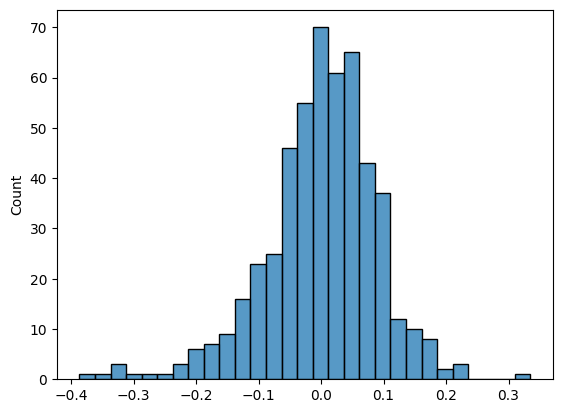

In [421]:
# Use the model to predict the output values for the training values of predictors
y_train_predicted = train_fit_5.predict(X_train_with_constant_5)

# Fetch the residuals based on the difference of the training output vs. actual output
train_residue = y_train - y_train_predicted
sns.histplot(train_residue)
plt.show()

The distribution of residuals shows a normal distribution of errors centered/peaking around 0.
This verifies the validity of the model for the training dataset.
Proceed with the evaluation of model with the testing dataset now.

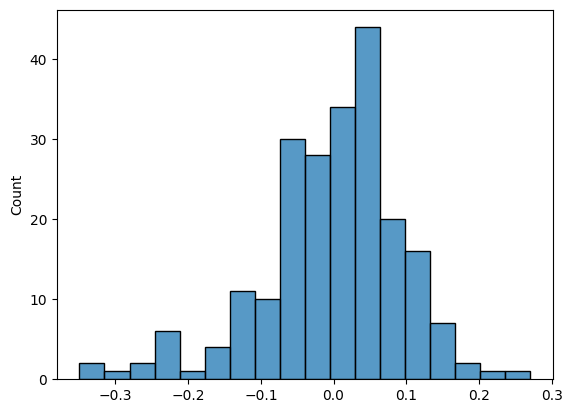

In [422]:
# Seperate the independent variable from the input data frame into another dataframe
# This is to test the model with dependent and independent dataframes
y_test  = df_test.pop('total_count')
X_test  = df_test

# Augument the independent variables of the testing dataset with **constant**
X_test_with_constant = sm.add_constant(X_test)

# Select only the columns of the testing dataset as provided by the built model
X_test_with_constant = X_test_with_constant[X_train_with_constant_5.columns]

# Use the model to predict the output values for the testing values of predictors
y_test_predicted = train_fit_5.predict(X_test_with_constant)

# Fetch the residuals based on the difference of the training output vs. actual output
test_residue = y_test - y_test_predicted
sns.histplot(test_residue)
plt.show()

The distribution of residuals shows a normal distribution of errors centered/peaking around 0 but slightly skewed towards right.
This is a slightly different than the distribution of the training dataset.

Overall the model shows fit with the testing dataset.

In [423]:
train_r2 = r2_score(y_train, y_train_predicted)
test_r2 = r2_score(y_test, y_test_predicted)

print("Train:",round(train_r2,3))
print("Test:",round(test_r2,3))

Train: 0.837
Test: 0.805


**R-squared of Training Dataset: 0.837 or 83.7%**

**R-squared of Testing Dataset:  0.805 or 80.5%**

In [424]:
# const          0.226132
# year           0.228910
# is_holiday    -0.097453
# temperature    0.570769
# humidity      -0.175596
# windspeed     -0.187000
# SUMMER         0.090651
# WINTER         0.139117
# LIT_RAIN      -0.235328
# MIST          -0.050318
# SEPTEMBER      0.106905
total_count = 0.226132 + (0.228910 * X_test.year) + \
                         (-0.097453 * X_test.is_holiday) + \
                         (0.570769 * X_test.temperature) + \
                         (0.175596 * X_test.humidity) + \
                         (-0.187000 * X_test.windspeed) + \
                         (0.090651 * X_test.SUMMER) + \
                         (0.139117 * X_test.WINTER) + \
                         (-0.235328 * X_test.LIT_RAIN) + \
                         (-0.050318 * X_test.MIST) + \
                         (0.106905 * X_test.SEPTEMBER)

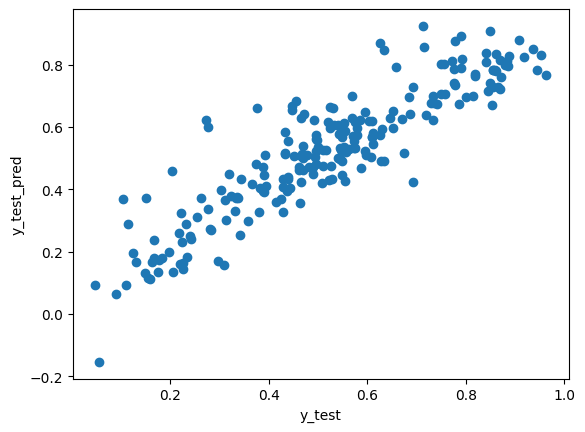

In [425]:
fig = plt.figure()
plt.scatter(y_test, y_test_predicted)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.show()

The graph shows high degree of collinearity between the actual and the predicted model proving validity of the model.

### Model without constant

In [426]:
# Create a model using the training data without **constant** model
# Fit the model
train_model_1a = sm.OLS(np.array(y_train), X_train)
train_fit_1a = train_model_1a.fit()
train_fit_1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                              1114.
Date:                Wed, 28 Aug 2024   Prob (F-statistic):                        0.00
Time:                        10:33:02   Log-Likelihood:                          476.59
No. Observations:                 510   AIC:                                     -923.2
Df Residuals:                     495   BIC:                                     -859.7
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
year            0.2368      0.009     27.327      0.000       0.220       0.254
is_holiday     -0.0936      0.028     -3.398      0.001      -0.148      -0.039
temperature     0.6882      0.031     22.260      0.000       0.627       0.749
humidity       -0.0008      0.036     -0.023      0.982      -0.071       0.069
windspeed      -0.1001      0.026     -3.915      0.000      -0.150      -0.050
SPRING          0.0537      0.018      2.968      0.003       0.018       0.089
SUMMER          0.1081      0.014      7.495      0.000       0.080       0.136
WINTER          0.1734      0.017     10.011      0.000       0.139       0.207
LIT_RAIN       -0.2783      0.028     -9.886      0.000      -0.334      -0.223
MIST           -0.0700      0.011     -6.323      0.000      -0.092      -0.048
DECEMBER       -0.0006      0.018     -0.031      0.975      -0.037       0.035
JANUARY        -0.0071      0.019     -0.374      0.708      -0.044       0.030
JULY           -0.0384      0.020     -1.970      0.049      -0.077     -0.0001
NOVEMBER       -0.0026      0.020     -0.134      0.893      -0.041       0.036
SEPTEMBER       0.1013      0.018      5.657      0.000       0.066       0.136
==============================================================================
Omnibus:                       59.657   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.554
Skew:                          -0.706   Prob(JB):                     1.62e-24
Kurtosis:                       4.778   Cond. No.                         14.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [427]:
VIF(X_train)

,Features,VIF
3,humidity,30.89
2,temperature,17.79
4,windspeed,4.72
5,SPRING,4.37
7,WINTER,4.06
6,SUMMER,2.82
9,MIST,2.32
0,year,2.09
13,NOVEMBER,1.85
11,JANUARY,1.75


In [428]:
# R2 = 0.970
# VIF high for humidity ~ 30.89
# p-valuye high for humidity ~ 0.982
# Drop the humidity column

X_train_without_constant_1 = X_train.drop(['humidity'], axis = 1)
train_model_1a = sm.OLS(np.array(y_train), X_train_without_constant_1)
train_fit_1a = train_model_1a.fit()
train_fit_1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                              1196.
Date:                Wed, 28 Aug 2024   Prob (F-statistic):                        0.00
Time:                        10:33:02   Log-Likelihood:                          476.59
No. Observations:                 510   AIC:                                     -925.2
Df Residuals:                     496   BIC:                                     -865.9
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
year            0.2368      0.009     27.456      0.000       0.220       0.254
is_holiday     -0.0936      0.028     -3.401      0.001      -0.148      -0.040
temperature     0.6876      0.017     41.306      0.000       0.655       0.720
windspeed      -0.1001      0.025     -3.939      0.000      -0.150      -0.050
SPRING          0.0535      0.015      3.637      0.000       0.025       0.082
SUMMER          0.1080      0.013      8.400      0.000       0.083       0.133
WINTER          0.1732      0.015     11.751      0.000       0.144       0.202
LIT_RAIN       -0.2785      0.026    -10.730      0.000      -0.329      -0.228
MIST           -0.0702      0.009     -7.722      0.000      -0.088      -0.052
DECEMBER       -0.0007      0.018     -0.038      0.970      -0.036       0.034
JANUARY        -0.0072      0.018     -0.390      0.697      -0.044       0.029
JULY           -0.0384      0.019     -1.972      0.049      -0.077      -0.000
NOVEMBER       -0.0027      0.020     -0.138      0.890      -0.041       0.036
SEPTEMBER       0.1012      0.018      5.780      0.000       0.067       0.136
==============================================================================
Omnibus:                       59.669   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.622
Skew:                          -0.706   Prob(JB):                     1.57e-24
Kurtosis:                       4.779   Cond. No.                         7.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [429]:
VIF(X_train_without_constant_1)

,Features,VIF
2,temperature,5.17
3,windspeed,4.67
6,WINTER,2.95
4,SPRING,2.89
5,SUMMER,2.24
0,year,2.07
12,NOVEMBER,1.81
10,JANUARY,1.66
11,JULY,1.59
8,MIST,1.57


In [430]:
# R2 = 0.970
# VIF are mostly in acceptable range with slightly higher value for temperature for which p-value is 0
# p-value high for DECEMBER ~ 0.970
# Drop the DECEMBER column

X_train_without_constant_2 = X_train_without_constant_1.drop(['DECEMBER'], axis = 1)
train_model_2a = sm.OLS(np.array(y_train), X_train_without_constant_2)
train_fit_2a = train_model_2a.fit()
train_fit_2a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                              1290.
Date:                Wed, 28 Aug 2024   Prob (F-statistic):                        0.00
Time:                        10:33:02   Log-Likelihood:                          476.59
No. Observations:                 510   AIC:                                     -927.2
Df Residuals:                     497   BIC:                                     -872.1
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
year            0.2368      0.009     27.486      0.000       0.220       0.254
is_holiday     -0.0936      0.027     -3.406      0.001      -0.148      -0.040
temperature     0.6876      0.017     41.433      0.000       0.655       0.720
windspeed      -0.1001      0.025     -3.943      0.000      -0.150      -0.050
SPRING          0.0534      0.014      3.715      0.000       0.025       0.082
SUMMER          0.1080      0.013      8.411      0.000       0.083       0.133
WINTER          0.1730      0.013     13.342      0.000       0.147       0.198
LIT_RAIN       -0.2784      0.026    -10.761      0.000      -0.329      -0.228
MIST           -0.0702      0.009     -7.734      0.000      -0.088      -0.052
JANUARY        -0.0071      0.018     -0.390      0.697      -0.043       0.029
JULY           -0.0384      0.019     -1.977      0.049      -0.077      -0.000
NOVEMBER       -0.0025      0.018     -0.134      0.894      -0.038       0.034
SEPTEMBER       0.1012      0.017      5.797      0.000       0.067       0.136
==============================================================================
Omnibus:                       59.591   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.400
Skew:                          -0.705   Prob(JB):                     1.75e-24
Kurtosis:                       4.777   Cond. No.                         7.13
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [431]:
VIF(X_train_without_constant_1)

,Features,VIF
2,temperature,5.17
3,windspeed,4.67
6,WINTER,2.95
4,SPRING,2.89
5,SUMMER,2.24
0,year,2.07
12,NOVEMBER,1.81
10,JANUARY,1.66
11,JULY,1.59
8,MIST,1.57


In [432]:
# R2 = 0.970
# VIF are mostly in acceptable range with slightly higher value for temperature for which p-value is 0
# p-value high for NOVEMBER ~ 0.894
# Drop the NOVEMBER column

X_train_without_constant_3 = X_train_without_constant_2.drop(['NOVEMBER'], axis = 1)
train_model_3a = sm.OLS(np.array(y_train), X_train_without_constant_3)
train_fit_3a = train_model_3a.fit()
train_fit_3a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              1401.
Date:                Wed, 28 Aug 2024   Prob (F-statistic):                        0.00
Time:                        10:33:02   Log-Likelihood:                          476.58
No. Observations:                 510   AIC:                                     -929.2
Df Residuals:                     498   BIC:                                     -878.3
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
year            0.2367      0.009     27.515      0.000       0.220       0.254
is_holiday     -0.0940      0.027     -3.452      0.001      -0.148      -0.041
temperature     0.6878      0.017     41.549      0.000       0.655       0.720
windspeed      -0.1004      0.025     -3.983      0.000      -0.150      -0.051
SPRING          0.0535      0.014      3.734      0.000       0.025       0.082
SUMMER          0.1080      0.013      8.428      0.000       0.083       0.133
WINTER          0.1722      0.011     15.041      0.000       0.150       0.195
LIT_RAIN       -0.2783      0.026    -10.775      0.000      -0.329      -0.228
MIST           -0.0702      0.009     -7.741      0.000      -0.088      -0.052
JANUARY        -0.0071      0.018     -0.390      0.696      -0.043       0.029
JULY           -0.0385      0.019     -1.979      0.048      -0.077      -0.000
SEPTEMBER       0.1014      0.017      5.834      0.000       0.067       0.136
==============================================================================
Omnibus:                       59.297   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.515
Skew:                          -0.704   Prob(JB):                     2.73e-24
Kurtosis:                       4.768   Cond. No.                         7.08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [433]:
VIF(X_train_without_constant_3)

,Features,VIF
2,temperature,5.13
3,windspeed,4.62
4,SPRING,2.75
5,SUMMER,2.24
0,year,2.07
6,WINTER,1.78
9,JANUARY,1.61
10,JULY,1.59
8,MIST,1.56
11,SEPTEMBER,1.34


In [434]:
# R2 = 0.971
# VIF are mostly in acceptable range with slightly higher value for temperature for which p-value is 0
# p-value high for JANUARY ~ 0.696
# Drop the JANUARY column

X_train_without_constant_4 = X_train_without_constant_3.drop(['JANUARY'], axis = 1)
train_model_4a = sm.OLS(np.array(y_train), X_train_without_constant_4)
train_fit_4a = train_model_4a.fit()
train_fit_4a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              1531.
Date:                Wed, 28 Aug 2024   Prob (F-statistic):                        0.00
Time:                        10:33:02   Log-Likelihood:                          476.50
No. Observations:                 510   AIC:                                     -931.0
Df Residuals:                     499   BIC:                                     -884.4
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
year            0.2366      0.009     27.556      0.000       0.220       0.253
is_holiday     -0.0942      0.027     -3.462      0.001      -0.148      -0.041
temperature     0.6883      0.016     41.783      0.000       0.656       0.721
windspeed      -0.0998      0.025     -3.971      0.000      -0.149      -0.050
SPRING          0.0507      0.012      4.077      0.000       0.026       0.075
SUMMER          0.1077      0.013      8.428      0.000       0.083       0.133
WINTER          0.1719      0.011     15.052      0.000       0.150       0.194
LIT_RAIN       -0.2782      0.026    -10.780      0.000      -0.329      -0.227
MIST           -0.0705      0.009     -7.811      0.000      -0.088      -0.053
JULY           -0.0390      0.019     -2.012      0.045      -0.077      -0.001
SEPTEMBER       0.1011      0.017      5.828      0.000       0.067       0.135
==============================================================================
Omnibus:                       59.366   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.985
Skew:                          -0.703   Prob(JB):                     2.16e-24
Kurtosis:                       4.775   Cond. No.                         6.99
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [435]:
VIF(X_train_without_constant_4)

,Features,VIF
2,temperature,5.09
3,windspeed,4.60
5,SUMMER,2.23
4,SPRING,2.08
0,year,2.07
6,WINTER,1.78
9,JULY,1.58
8,MIST,1.55
10,SEPTEMBER,1.34
7,LIT_RAIN,1.08


In [436]:
# R2 = 0.971
# VIF are mostly in acceptable range with slightly higher value for temperature for which p-value is 0
# p-value high for JULY ~ 0.045
# Drop the JULY column

X_train_without_constant_5 = X_train_without_constant_4.drop(['JULY'], axis = 1)
train_model_5a = sm.OLS(np.array(y_train), X_train_without_constant_5)
train_fit_5a = train_model_5a.fit()
train_fit_5a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                              1673.
Date:                Wed, 28 Aug 2024   Prob (F-statistic):                        0.00
Time:                        10:33:02   Log-Likelihood:                          474.44
No. Observations:                 510   AIC:                                     -928.9
Df Residuals:                     500   BIC:                                     -886.5
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
year            0.2369      0.009     27.515      0.000       0.220       0.254
is_holiday     -0.0935      0.027     -3.424      0.001      -0.147      -0.040
temperature     0.6719      0.014     46.837      0.000       0.644       0.700
windspeed      -0.1015      0.025     -4.028      0.000      -0.151      -0.052
SPRING          0.0558      0.012      4.564      0.000       0.032       0.080
SUMMER          0.1175      0.012      9.917      0.000       0.094       0.141
WINTER          0.1786      0.011     16.299      0.000       0.157       0.200
LIT_RAIN       -0.2790      0.026    -10.780      0.000      -0.330      -0.228
MIST           -0.0697      0.009     -7.710      0.000      -0.087      -0.052
SEPTEMBER       0.1111      0.017      6.654      0.000       0.078       0.144
==============================================================================
Omnibus:                       63.207   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.673
Skew:                          -0.737   Prob(JB):                     2.80e-26
Kurtosis:                       4.834   Cond. No.                         6.98
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [437]:
VIF(X_train_without_constant_5)

,Features,VIF
3,windspeed,4.60
2,temperature,3.84
0,year,2.07
4,SPRING,1.99
5,SUMMER,1.90
6,WINTER,1.63
8,MIST,1.55
9,SEPTEMBER,1.23
7,LIT_RAIN,1.08
1,is_holiday,1.04


In [438]:
# R2 = 0.970
# VIF's are in acceptable range
# P-value of all predictors is 0
# Considering this as the **FINAL** model
train_fit_5a.params

year           0.236900
is_holiday    -0.093459
temperature    0.671892
windspeed     -0.101548
SPRING         0.055794
SUMMER         0.117481
WINTER         0.178648
LIT_RAIN      -0.278983
MIST          -0.069726
SEPTEMBER      0.111056
dtype: float64

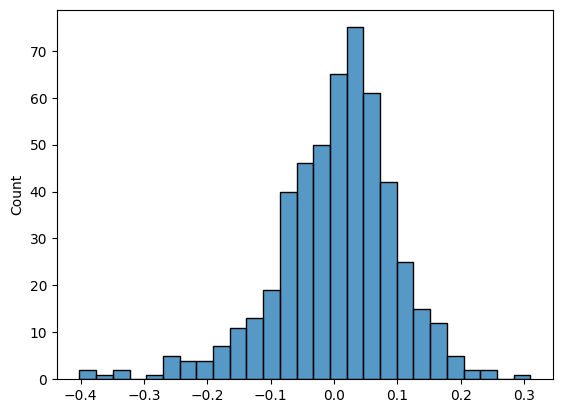

In [439]:
# Use the model to predict the output values for the training values of predictors
y_train_predicted_without_constant = train_fit_5a.predict(X_train_without_constant_5)

# Fetch the residuals based on the difference of the training output vs. actual output
train_residue_without_constant = y_train - y_train_predicted_without_constant
sns.histplot(train_residue_without_constant)
plt.show()

The distribution of residuals shows a normal distribution of errors centered/peaking around 0.
This verifies the validity of the model for the training dataset.
Proceed with the evaluation of model with the testing dataset now.

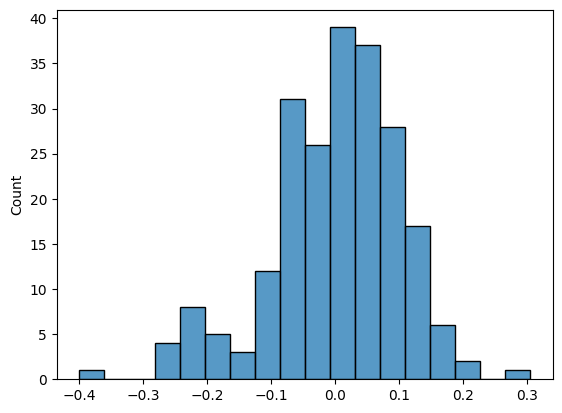

In [440]:
# Select only the columns of the testing dataset as provided by the built model
X_test_without_constant = X_test[X_train_without_constant_5.columns]

# Use the model to predict the output values for the testing values of predictors
y_test_predicted_without_constant = train_fit_5a.predict(X_test_without_constant)

# Fetch the residuals based on the difference of the training output vs. actual output
test_residue_without_constant = y_test - y_test_predicted_without_constant
sns.histplot(test_residue_without_constant)
plt.show()

In [441]:
train_r2_without_constant = r2_score(y_train, y_train_predicted_without_constant)
test_r2_without_constant = r2_score(y_test, y_test_predicted_without_constant)

print("Train:",round(train_r2_without_constant,3))
print("Test:",round(test_r2_without_constant,3))

Train: 0.819
Test: 0.782
